<a href="https://colab.research.google.com/github/eduardopadilla3/Unit2_BW_code/blob/master/Unit2project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from time import strftime
import os

curr_path = os.getcwd()
csv_name = 'str_hilo_hkjc.csv'
output_file = '%s\\data\\%s' % (curr_path,csv_name)
error_file = '%s\\error.txt' % (curr_path)
if os.path.exists(error_file):
    os.remove(error_file)

ou_hdc = 'OU25'

# Match date
from datetime import datetime, timedelta, date, time
current_match_date = datetime.now()
current_time = datetime.now().time()
if current_time >= time(0,0) and current_time <= time(11, 30):
    previous_day = current_match_date - timedelta(days=1)
    current_match_date = previous_day
db_match_date = current_match_date.strftime("%Y%m%d")
current_match_date = current_match_date.strftime("%Y-%m-%d 11:30:00")

print('Last execution time: %s' % strftime('%Y-%m-%d %H:%M:%S'))

Last execution time: 2020-10-07 23:10:23


In [2]:
import cx_Oracle
import codecs

db_user = 'JW'
db_password = '901203'
db_dsn = 'HOME-PC/XE'
db_encoding = 'UTF-8'

# Database connection
connection = None
try:
    connection = cx_Oracle.connect(
        db_user,
        db_password,
        db_dsn,
        encoding=db_encoding)

    c = connection.cursor()
    file = codecs.open(output_file, "a+", "utf-8")

    if os.path.exists(output_file):
        os.remove(output_file)

    # write file header
    file.write('MATCH_ID,MATCH_DATETIME,LEAGUE,HOME_TEAM,AWAY_TEAM,HOME_FT_GOAL,AWAY_FT_GOAL,TOTAL_GOAL_COUNT,ML_TYPE,STR_OU_HKJC_HDC,STR_OU_MACAU_HDC,STR_OU_AVG_HI,STR_OU_MEDIAN_HI,STR_OU_HKJC_HI,STR_OU_MACAU_HI,STR_OU_HKJC_HI_DIFF,STR_OU_AVG_LO,STR_OU_MEDIAN_LO,STR_OU_HKJC_LO,STR_OU_MACAU_LO,STR_OU_HKJC_LO_DIFF,STR_HKJC_H,STR_HKJC_D,STR_HKJC_A\n')
    sql = """
        SELECT
            info.MATCH_ID, info.MATCH_DATETIME, info.LEAGUE, info.HOME_TEAM, info.AWAY_TEAM, info.HOME_FT_GOAL, info.AWAY_FT_GOAL, info.HOME_FT_GOAL+info.AWAY_FT_GOAL AS TOTAL_GOAL_COUNT, 
            CASE 
                WHEN info.MATCH_DATETIME < TO_TIMESTAMP('2020-06-01 00:00:00', 'YYYY-MM-DD HH24:MI:SS') THEN 'TRAIN'
                WHEN info.MATCH_DATETIME >= TO_TIMESTAMP('2020-06-01 00:00:00', 'YYYY-MM-DD HH24:MI:SS') AND info.MATCH_DATETIME < TO_TIMESTAMP('2020-09-01 00:00:00', 'YYYY-MM-DD HH24:MI:SS') THEN 'VALID'
                WHEN info.MATCH_DATETIME >= TO_TIMESTAMP('2020-09-01 00:00:00', 'YYYY-MM-DD HH24:MI:SS') AND info.MATCH_DATETIME < TO_TIMESTAMP('%s', 'YYYY-MM-DD HH24:MI:SS') THEN 'TEST'
                WHEN info.MATCH_DATETIME >= TO_TIMESTAMP('%s', 'YYYY-MM-DD HH24:MI:SS') THEN 'PREDICT'
            END AS ML_TYPE, 
            hilo.STR_HKJC_HDC AS STR_OU_HKJC_HDC, hilo.STR_MACAU_HDC AS STR_OU_MACAU_HDC,
            ROUND(hilo.STR_O_AVG_HI,4) AS STR_OU_AVG_HI, hilo.STR_O_MEDIAN_HI AS STR_OU_MEDIAN_HI, hilo.STR_O_HKJC_HI AS STR_OU_HKJC_HI, hilo.STR_O_MACAU_HI AS STR_OU_MACAU_HI, 
            ROUND((hilo.STR_O_HKJC_HI-hilo.STR_O_AVG_HI)/hilo.STR_O_AVG_HI,4) AS STR_OU_HKJC_HI_DIFF, 
            ROUND(hilo.STR_O_AVG_LO,4) AS STR_OU_AVG_LO, hilo.STR_O_MEDIAN_LO AS STR_OU_MEDIAN_LO, hilo.STR_O_HKJC_LO AS STR_OU_HKJC_LO, hilo.STR_O_MACAU_LO AS STR_OU_MACAU_LO, 
            ROUND((hilo.STR_O_HKJC_LO-hilo.STR_O_AVG_LO)/hilo.STR_O_AVG_LO,4) AS STR_OU_HKJC_LO_DIFF, 
            hkjc.HOME_ODD AS STR_HKJC_H, 
            hkjc.DRAW_ODD AS STR_HKJC_D, 
            hkjc.AWAY_ODD AS STR_HKJC_A 
        FROM
            HILO_MERGE2 hilo, MATCH_INFO info, HDA_RAW hkjc
        WHERE
            info.MATCH_ID=hilo.MATCH_ID AND info.MATCH_ID=hkjc.MATCH_ID
            AND hkjc.BOOKMAKER='香港马会'
            AND hkjc.HANDICAP_TYPE=0
            AND hilo.STR_MODE_HDC IS NOT NULL AND hilo.STR_HKJC_HDC IS NOT NULL AND hilo.STR_MACAU_HDC IS NOT NULL 
            AND ROUND(hilo.STR_O_AVG_HI,4) IS NOT NULL AND hilo.STR_O_MEDIAN_HI IS NOT NULL AND hilo.STR_O_HKJC_HI IS NOT NULL 
            AND ROUND(hilo.STR_O_AVG_LO,4) IS NOT NULL AND hilo.STR_O_MEDIAN_LO IS NOT NULL AND hilo.STR_O_HKJC_LO IS NOT NULL 
            AND hkjc.HOME_ODD IS NOT NULL 
            AND hkjc.DRAW_ODD IS NOT NULL 
            AND hkjc.AWAY_ODD IS NOT NULL 
            AND hilo.STR_MODE_HDC=hilo.STR_HKJC_HDC
            AND (info.MATCH_DATETIME >= TO_TIMESTAMP('%s', 'YYYY-MM-DD HH24:MI:SS') OR (info.MATCH_DATETIME < TO_TIMESTAMP('%s', 'YYYY-MM-DD HH24:MI:SS') AND info.HOME_FT_GOAL IS NOT NULL))
        ORDER BY info.MATCH_DATETIME, info.MATCH_ID
        """ % (current_match_date, current_match_date, current_match_date, current_match_date)

    c.execute(sql)
    result = c.fetchall()
    for row in result:
        ft_home_goal = row[5]
        ft_away_goal = row[6]
        total_goal = row[7]
        if row[5] == None:
            ft_home_goal = ''
        if row[6] == None:
            ft_away_goal = ''
        if row[7] == None:
            total_goal = ''
        file.write('%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s,%s\n' % (
            row[0], row[1], row[2], row[3], row[4], ft_home_goal, ft_away_goal, total_goal, row[8], row[9], row[10], row[11], row[12], row[13], row[14], row[15], row[16], row[17], row[18], row[19], row[20], row[21], row[22], row[23]))

    file.close()

except cx_Oracle.Error as error:
    file.close()
    err_file = codecs.open(error_file, 'a+', 'utf-8')
    err_file.write('[%s] Oracle error - %s\n' % (strftime('%Y-%m-%d %H:%M:%S'), error))
    err_file.close()
except:
    file.close()

In [3]:
import pandas as pd
from datetime import datetime

In [4]:
pd.set_option('display.width', 3000)
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 3000)

In [5]:
#load datasets
df = pd.read_csv('data/%s' % csv_name, sep=',')

In [6]:
# #final feature selection
df = df[['MATCH_ID', 'MATCH_DATETIME', 'LEAGUE', 'HOME_TEAM', 'AWAY_TEAM', 'HOME_FT_GOAL', 'AWAY_FT_GOAL', 'TOTAL_GOAL_COUNT', 'ML_TYPE', 'STR_OU_HKJC_HDC', 'STR_OU_MACAU_HDC', 'STR_OU_AVG_HI', 'STR_OU_MEDIAN_HI', 'STR_OU_HKJC_HI', 'STR_OU_MACAU_HI', 'STR_OU_HKJC_HI_DIFF', 'STR_OU_AVG_LO', 'STR_OU_MEDIAN_LO', 'STR_OU_HKJC_LO', 'STR_OU_MACAU_LO', 'STR_OU_HKJC_LO_DIFF', 'STR_HKJC_H', 'STR_HKJC_D', 'STR_HKJC_A']]

df['OU25'] = [1 if x > 2.5 else 0 for x in df['TOTAL_GOAL_COUNT']]


In [7]:
df.head()

,MATCH_ID,MATCH_DATETIME,LEAGUE,HOME_TEAM,AWAY_TEAM,HOME_FT_GOAL,AWAY_FT_GOAL,TOTAL_GOAL_COUNT,ML_TYPE,STR_OU_HKJC_HDC,STR_OU_MACAU_HDC,STR_OU_AVG_HI,STR_OU_MEDIAN_HI,STR_OU_HKJC_HI,STR_OU_MACAU_HI,STR_OU_HKJC_HI_DIFF,STR_OU_AVG_LO,STR_OU_MEDIAN_LO,STR_OU_HKJC_LO,STR_OU_MACAU_LO,STR_OU_HKJC_LO_DIFF,STR_HKJC_H,STR_HKJC_D,STR_HKJC_A,OU25
0,1721170,2019-09-20 22:30:00,俄超,烏法,莫斯科斯巴達,1.0,0.0,1.0,TRAIN,2.25,2.25,1.1111,1.050,1.05,1.05,-0.0550,0.7433,0.720,0.68,0.65,-0.0852,3.25,2.92,2.12,0
1,1650601,2019-09-21 01:00:00,瑞典超,辛斯華爾,佐加頓斯,1.0,4.0,5.0,TRAIN,2.50,2.50,0.8371,0.835,0.78,0.83,-0.0683,0.9907,1.015,0.92,0.87,-0.0714,5.55,3.80,1.47,1
2,1725329,2019-09-21 02:00:00,荷乙,伊高斯,阿積士青年隊,1.0,1.0,2.0,TRAIN,3.50,3.50,0.8678,0.920,0.70,0.63,-0.1933,0.9522,0.930,1.02,0.97,0.0712,2.05,4.00,2.60,0
3,1763441,2019-09-21 02:45:00,意甲,卡利亞里,熱拿亞,3.0,1.0,4.0,TRAIN,2.50,2.50,0.9600,0.970,0.85,0.87,-0.1146,0.8967,0.900,0.85,0.93,-0.0520,2.45,3.25,2.45,1
4,1662718,2019-09-21 16:00:00,韓K聯,浦項制鐵,FC首爾,2.0,1.0,3.0,TRAIN,2.50,2.50,0.9627,0.970,0.85,0.88,-0.1170,0.8680,0.850,0.85,0.82,-0.0207,2.05,3.20,3.10,1


In [8]:
df1=df.drop(['MATCH_ID','MATCH_DATETIME','LEAGUE','HOME_TEAM','AWAY_TEAM','HOME_FT_GOAL','AWAY_FT_GOAL','TOTAL_GOAL_COUNT'], axis=1)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import category_encoders as ce
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

In [10]:
#Split train and test datasets

X = df1
X_train = df1.query('ML_TYPE == "TRAIN"')
X_val = df1.query('ML_TYPE == "VALID"')
X_test = df1.query('ML_TYPE == "TEST" | ML_TYPE == "PREDICT"')
y_train = X_train.pop(ou_hdc)
y_val = X_val.pop(ou_hdc)
y_test = X_test.pop(ou_hdc)

In [11]:
#confirm size of datasets
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(1903, 16)
(605, 16)
(428, 16)
(1903,)
(605,)
(428,)


In [12]:
# Baseline
y_train.value_counts(normalize=True)

0    0.508671
1    0.491329
Name: OU25, dtype: float64

In [13]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [14]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

C:\Users\willi\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\willi\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


PermutationImportance(estimator=RandomForestClassifier(n_jobs=-1,
                                                       random_state=42),
                      random_state=42, scoring='accuracy')

In [15]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_test.columns.tolist()
)

Weight,Feature
0.0040 ± 0.0095,STR_OU_MACAU_HDC
0.0040 ± 0.0061,STR_OU_HKJC_HDC
0 ± 0.0000,ML_TYPE
-0.0010 ± 0.0074,STR_OU_HKJC_LO
-0.0010 ± 0.0088,STR_OU_HKJC_HI
-0.0066 ± 0.0202,STR_OU_MACAU_LO
-0.0079 ± 0.0166,STR_OU_MEDIAN_HI
-0.0096 ± 0.0200,STR_OU_AVG_LO
-0.0102 ± 0.0138,STR_OU_HKJC_LO_DIFF
-0.0116 ± 0.0145,STR_HKJC_H


In [16]:
from xgboost import XGBClassifier
model1 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=20, random_state=42, n_jobs=-1)
)

model1.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['ML_TYPE'],
                                mapping=[{'col': 'ML_TYPE',
                                          'data_type': dtype('O'),
                                          'mapping': TRAIN    1
NaN     -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=20,
                               n_jobs=-1, num_parallel_tree

In [17]:
print('Training Accuracy:', model1.score(X_train, y_train))
print('Validation Accuracy:', model1.score(X_val, y_val))
print('Test Accuracy:', model1.score(X_test, y_test))


Training Accuracy: 0.8665265370467683
Validation Accuracy: 0.512396694214876
Test Accuracy: 0.49065420560747663


In [18]:
model2 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
model2.fit(X_train, y_train)

print('training accuracy:', model2.score(X_train, y_train))
print('validation accuracy:', model2.score(X_val, y_val))
print('test accuracy:', model2.score(X_test, y_test))

training accuracy: 1.0
validation accuracy: 0.48925619834710743
test accuracy: 0.4953271028037383


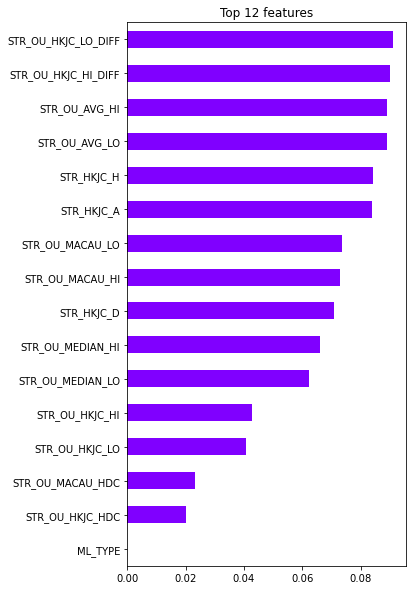

In [19]:
# Get feature importances
rf = model2.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

n = 12
plt.figure(figsize=(5,10))
plt.title(f'Top {n} features')
importances.sort_values().plot.barh(color = iter(cm.rainbow(np.linspace(-1.1,1.5))));

In [20]:
model3 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    LogisticRegression(max_iter=1600, random_state=42)
)

model3.fit(X_train, y_train)

print('Training Accuracy:', model3.score(X_train, y_train))
print('Validation Accuracy:', model3.score(X_val, y_val))
print('Test Accuracy:', model3.score(X_test, y_test))


Training Accuracy: 0.5648975302154493
Validation Accuracy: 0.5239669421487604
Test Accuracy: 0.4953271028037383


In [21]:
#remove negative features
X_train = X_train[['STR_OU_HKJC_HI','STR_OU_HKJC_LO','STR_OU_AVG_HI','STR_OU_HKJC_HDC']]
X_val = X_val[['STR_OU_HKJC_HI','STR_OU_HKJC_LO','STR_OU_AVG_HI','STR_OU_HKJC_HDC']]
X_test = X_test[['STR_OU_HKJC_HI','STR_OU_HKJC_LO','STR_OU_AVG_HI','STR_OU_HKJC_HDC']]

# X_train = X_train[['AWAY_AWAY_AVG_GF','STR_HKJC_D','AWAY_AVG_GF','HOME_ADV','AWAY_TOTAL_GA','STR_OU_HKJC_LO','HOME_TOTAL_GA','HOME_HOME_GF','HOME_HOME_AVG_GF','STR_OU_MEDIAN_LO','HOME_TOTAL_GF','AWAY_AWAY_GA','STR_HKJC_H','GAME_POINT','STR_OU_AVG_LO','STR_HKJC_A','AWAY_AWAY_GF','HOME_AVG_GF','HOME_HOME_GA','STR_OU_MEDIAN_HI','AWAY_TOTAL_GF']]
# X_val = X_val[['AWAY_AWAY_AVG_GF','STR_HKJC_D','AWAY_AVG_GF','HOME_ADV','AWAY_TOTAL_GA','STR_OU_HKJC_LO','HOME_TOTAL_GA','HOME_HOME_GF','HOME_HOME_AVG_GF','STR_OU_MEDIAN_LO','HOME_TOTAL_GF','AWAY_AWAY_GA','STR_HKJC_H','GAME_POINT','STR_OU_AVG_LO','STR_HKJC_A','AWAY_AWAY_GF','HOME_AVG_GF','HOME_HOME_GA','STR_OU_MEDIAN_HI','AWAY_TOTAL_GF']]
# X_test = X_test[['AWAY_AWAY_AVG_GF','STR_HKJC_D','AWAY_AVG_GF','HOME_ADV','AWAY_TOTAL_GA','STR_OU_HKJC_LO','HOME_TOTAL_GA','HOME_HOME_GF','HOME_HOME_AVG_GF','STR_OU_MEDIAN_LO','HOME_TOTAL_GF','AWAY_AWAY_GA','STR_HKJC_H','GAME_POINT','STR_OU_AVG_LO','STR_HKJC_A','AWAY_AWAY_GF','HOME_AVG_GF','HOME_HOME_GA','STR_OU_MEDIAN_HI','AWAY_TOTAL_GF']]

In [22]:
from xgboost import XGBClassifier
model1 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(n_estimators=12, random_state=42, n_jobs=-1, learning_rate=0.097, subsample=1)
)

model1.fit(X_train, y_train)

print('Training Accuracy:', model1.score(X_train, y_train))
print('Validation Accuracy:', model1.score(X_val, y_val))
print('Test Accuracy:', model1.score(X_test, y_test))


Training Accuracy: 0.6458223857067787
Validation Accuracy: 0.5074380165289256
Test Accuracy: 0.5163551401869159


In [23]:
model2 = Pipeline([
                  ('oe', ce.OrdinalEncoder()),
                  ('impute', SimpleImputer(strategy='mean')),
                  ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

model2.fit(X_train, y_train)

print('training accuracy:', model2.score(X_train, y_train))
print('validation accuracy:', model2.score(X_val, y_val))
print('test accuracy:', model2.score(X_test, y_test))

training accuracy: 0.9837099316868103
validation accuracy: 0.5008264462809917
test accuracy: 0.530373831775701


In [24]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [25]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(estimator=RandomForestClassifier(n_jobs=-1,
                                                       random_state=42),
                      random_state=42, scoring='accuracy')

In [26]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names=X_test.columns.tolist()
)

Weight,Feature
0.0086 ± 0.0470,STR_OU_AVG_HI
0.0013 ± 0.0109,STR_OU_HKJC_HDC
-0.0020 ± 0.0232,STR_OU_HKJC_HI
-0.0192 ± 0.0178,STR_OU_HKJC_LO


In [27]:
model3 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    LogisticRegression(max_iter=800, random_state=42)
)

model3.fit(X_train, y_train)

print('Training Accuracy:', model3.score(X_train, y_train))
print('Validation Accuracy:', model3.score(X_val, y_val))
print('Test Accuracy:', model3.score(X_test, y_test))


Training Accuracy: 0.5496584340514976
Validation Accuracy: 0.5223140495867769
Test Accuracy: 0.4976635514018692


In [28]:
import matplotlib.pyplot as plt


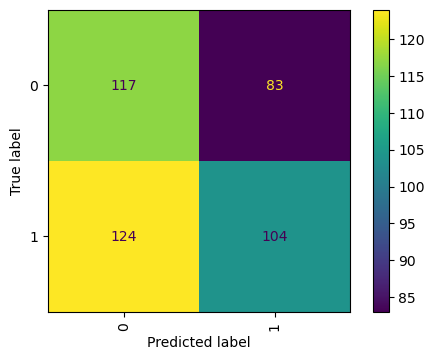

In [29]:
#Confusion graph
from sklearn.metrics import plot_confusion_matrix, classification_report

plt.rcParams['figure.dpi'] = 100
plot_confusion_matrix(model1, X_test, y_test, values_format='.0f', xticks_rotation='vertical')

In [30]:
# df1.tail()

In [31]:
final = df[['MATCH_ID','MATCH_DATETIME', 'ML_TYPE', 'LEAGUE', 'HOME_TEAM', 'AWAY_TEAM', 'HOME_FT_GOAL', 'AWAY_FT_GOAL', 'STR_OU_MACAU_HDC', 'STR_OU_MACAU_HI', 'STR_OU_MACAU_LO', 'STR_OU_HKJC_HDC', 'STR_OU_HKJC_HI', 'STR_OU_HKJC_LO', 'TOTAL_GOAL_COUNT', ou_hdc]]

final = final.query('ML_TYPE == "TEST" | ML_TYPE == "PREDICT"')

In [32]:
y_pred = model1.predict(X_test)
class_probabilities = model1.predict_proba(X_test)

pred = pd.DataFrame(y_pred, columns=['pred'])
prob = pd.DataFrame(class_probabilities, columns=['prob0','prob1' ])

final.reset_index(drop=True, inplace=True)
pred.reset_index(drop=True, inplace=True)
prob.reset_index(drop=True, inplace=True)

fin = pd.concat([final, prob, pred], axis=1)


In [33]:
# for i,j in fin.iterrows():
#     if fin.loc[i, 'prob0'] >= 0.6:
#         print(fin.loc[[i]])
#         print('%s	%s	%s	%s	%s	%s	%s	%s	%s	%s	%s	%s	%s' % (fin.loc[i, 'MATCH_DATETIME'],fin.loc[i, 'HOME_TEAM'],fin.loc[i, 'AWAY_TEAM'],fin.loc[i, 'HOME_FT_GOAL'],fin.loc[i, 'AWAY_FT_GOAL'],fin.loc[i, 'STR_HKJC_HILO_HANDICAP'],fin.loc[i, 'STR_HKJC_HILO_HI'],fin.loc[i, 'STR_HKJC_HILO_LO'],fin.loc[i, 'TOTAL_GOAL_COUNT'],fin.loc[i, 'OU25'],fin.loc[i, 'prob0'],fin.loc[i, 'prob1'],fin.loc[i, 'pred']))

In [34]:
# fin['Correct'] = (fin[ou_hdc] == fin['pred']).astype(int)


In [35]:
#def a(fin):
#    if (fin['prob0'] >= 0.55 or fin['prob1'] >= 0.55):
#        return 1
#    else:
#      return 0
#fin = fin.assign(O55=fin.apply(a, axis=1))

In [36]:
bet_amount = 1000

home_goal_col = 'HOME_FT_GOAL'
away_goal_col = 'AWAY_FT_GOAL'

macau_hdc_col = 'STR_OU_MACAU_HDC'
macau_hi_col = 'STR_OU_MACAU_HI'
macau_lo_col = 'STR_OU_MACAU_LO'

hkjc_hdc_col = 'STR_OU_HKJC_HDC'
hkjc_hi_col = 'STR_OU_HKJC_HI'
hkjc_lo_col = 'STR_OU_HKJC_LO'

In [37]:
# fin['Correct'] = (fin[ou_hdc] == fin['pred']).astype(int)
import math

for i,j in fin.iterrows():
    if fin.loc[i, home_goal_col]+fin.loc[i, away_goal_col] > fin.loc[i, macau_hdc_col]:
        fin.loc[i, 'Correct_MS'] = str('1')
    elif fin.loc[i, home_goal_col]+fin.loc[i, away_goal_col] == fin.loc[i, macau_hdc_col]:
        fin.loc[i, 'Correct_MS'] = str('-')
    elif math.isnan(fin.loc[i, home_goal_col]):
        fin.loc[i, home_goal_col] = None
        fin.loc[i, away_goal_col] = None
        fin.loc[i, ou_hdc] = None
        fin.loc[i, 'Correct_MS'] = str('NaN')
    else:
        fin.loc[i, 'Correct_MS'] = str('0')
        
    if fin.loc[i, home_goal_col]+fin.loc[i, away_goal_col] > fin.loc[i, hkjc_hdc_col]:
        fin.loc[i, 'Correct_JC'] = str('1')
    elif fin.loc[i, home_goal_col]+fin.loc[i, away_goal_col] == fin.loc[i, hkjc_hdc_col]:
        fin.loc[i, 'Correct_JC'] = str('-')
    elif math.isnan(fin.loc[i, home_goal_col]):
        fin.loc[i, home_goal_col] = None
        fin.loc[i, away_goal_col] = None
        fin.loc[i, ou_hdc] = None
        fin.loc[i, 'Correct_JC'] = str('NaN')
    else:
        fin.loc[i, 'Correct_JC'] = str('0')
        
# fin

In [38]:
#betting on every single match
macau_money = []
macau_count = 0
hkjc_money = []
hkjc_count = 0

for i,j in fin.iterrows():
    if fin.loc[i, 'prob1'] >= 0.53:
        # HKJC
        if fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] > fin.loc[i, hkjc_hdc_col]:
            hkjc_count = (hkjc_count + (bet_amount*fin.loc[i, hkjc_hi_col]))
            hkjc_money.append(hkjc_count)
        elif fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] == fin.loc[i, hkjc_hdc_col]:
            hkjc_money.append(hkjc_count)
        else:
            hkjc_count = hkjc_count - bet_amount
            hkjc_money.append(hkjc_count)
    else:
        macau_money.append(macau_count)
        hkjc_money.append(hkjc_count)

fin.loc[:, 'Model1_JC'] = pd.Series(hkjc_money)

In [39]:
#betting on every over (baseline)
macau_money = []
macau_count = 0
hkjc_money = []
hkjc_count = 0

for i,j in fin.iterrows():
    if fin.loc[i, 'prob1'] >= 0.5:
        # HKJC
        if fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] > fin.loc[i, hkjc_hdc_col]:
            hkjc_count = (hkjc_count + (bet_amount*fin.loc[i, hkjc_hi_col]))
            hkjc_money.append(hkjc_count)
        elif fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] == fin.loc[i, hkjc_hdc_col]:
            hkjc_money.append(hkjc_count)
        else:
            hkjc_count = hkjc_count - bet_amount
            hkjc_money.append(hkjc_count)
    else:
        macau_money.append(macau_count)
        hkjc_money.append(hkjc_count)

fin.loc[:, 'Baseline_JC'] = pd.Series(hkjc_money)

In [40]:
fin[ou_hdc].value_counts(normalize=True)

1.0    0.535211
0.0    0.464789
Name: OU25, dtype: float64

In [41]:
# fin

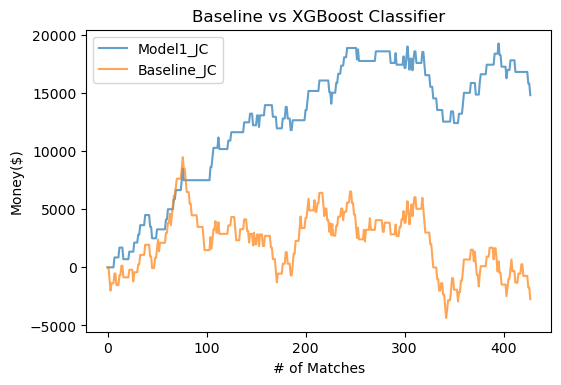

In [42]:
fin.plot(y=["Model1_JC", "Baseline_JC"], alpha=0.7)
plt.title('Baseline vs XGBoost Classifier')
plt.xlabel('# of Matches')
plt.ylabel('Money($)')

plt.show()

In [43]:
fin = fin.drop(["Model1_JC", "Baseline_JC"], axis=1)

In [44]:
#betting on only 53% Confidence 
macau_money = []
macau_count = 0 
hkjc_money = []
hkjc_count = 0 
prob = 0.53

for i,j in fin.iterrows():
    if fin.loc[i, 'prob1'] >= prob:
        # Macau
        if fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] > fin.loc[i, macau_hdc_col]:
            macau_count = (macau_count + (bet_amount*fin.loc[i, macau_hi_col]))
            macau_money.append(macau_count)
        elif fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] == fin.loc[i, macau_hdc_col]:
            macau_money.append(macau_count)
        else:
            macau_count = macau_count - bet_amount
            macau_money.append(macau_count)
            
        # HKJC
        if fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] > fin.loc[i, hkjc_hdc_col]:
            hkjc_count = (hkjc_count + (bet_amount*fin.loc[i, hkjc_hi_col]))
            hkjc_money.append(hkjc_count)
        elif fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] == fin.loc[i, hkjc_hdc_col]:
            hkjc_money.append(hkjc_count)
        else:
            hkjc_count = hkjc_count - bet_amount
            hkjc_money.append(hkjc_count)
    else:
        macau_money.append(macau_count)
        hkjc_money.append(hkjc_count)
    
fin.loc[:, 'MS_PL_0.53'] = pd.Series(macau_money)
fin.loc[:, 'JC_PL_0.53'] = pd.Series(hkjc_money)

In [45]:
#betting on only 55% Confidence 
macau_money = []
macau_count = 0 
hkjc_money = []
hkjc_count = 0 
prob = 0.55

for i,j in fin.iterrows():
    if fin.loc[i, 'prob1'] >= prob:
        # Macau
        if fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] > fin.loc[i, macau_hdc_col]:
            macau_count = (macau_count + (bet_amount*fin.loc[i, macau_hi_col]))
            macau_money.append(macau_count)
        elif fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] == fin.loc[i, macau_hdc_col]:
            macau_money.append(macau_count)
        else:
            macau_count = macau_count - bet_amount
            macau_money.append(macau_count)
            
        # HKJC
        if fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] > fin.loc[i, hkjc_hdc_col]:
            hkjc_count = (hkjc_count + (bet_amount*fin.loc[i, hkjc_hi_col]))
            hkjc_money.append(hkjc_count)
        elif fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] == fin.loc[i, hkjc_hdc_col]:
            hkjc_money.append(hkjc_count)
        else:
            hkjc_count = hkjc_count - bet_amount
            hkjc_money.append(hkjc_count)
    else:
        macau_money.append(macau_count)
        hkjc_money.append(hkjc_count)
    
fin.loc[:, 'MS_PL_0.55'] = pd.Series(macau_money)
fin.loc[:, 'JC_PL_0.55'] = pd.Series(hkjc_money)

In [46]:
#betting on only 60% Confidence 
macau_money = []
macau_count = 0 
hkjc_money = []
hkjc_count = 0 
prob = 0.6

for i,j in fin.iterrows():
    if fin.loc[i, 'prob1'] >= prob:
        # Macau
        if fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] > fin.loc[i, macau_hdc_col]:
            macau_count = (macau_count + (bet_amount*fin.loc[i, macau_hi_col]))
            macau_money.append(macau_count)
        elif fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] == fin.loc[i, macau_hdc_col]:
            macau_money.append(macau_count)
        else:
            macau_count = macau_count - bet_amount
            macau_money.append(macau_count)
            
        # HKJC
        if fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] > fin.loc[i, hkjc_hdc_col]:
            hkjc_count = (hkjc_count + (bet_amount*fin.loc[i, hkjc_hi_col]))
            hkjc_money.append(hkjc_count)
        elif fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] == fin.loc[i, hkjc_hdc_col]:
            hkjc_money.append(hkjc_count)
        else:
            hkjc_count = hkjc_count - bet_amount
            hkjc_money.append(hkjc_count)
    else:
        macau_money.append(macau_count)
        hkjc_money.append(hkjc_count)
    
fin.loc[:, 'MS_PL_0.60'] = pd.Series(macau_money)
fin.loc[:, 'JC_PL_0.60'] = pd.Series(hkjc_money)

In [47]:
#betting on only 65% Confidence 
macau_money = []
macau_count = 0 
hkjc_money = []
hkjc_count = 0 
prob = 0.65

for i,j in fin.iterrows():
    if fin.loc[i, 'prob1'] >= prob:
        # Macau
        if fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] > fin.loc[i, macau_hdc_col]:
            macau_count = (macau_count + (bet_amount*fin.loc[i, macau_hi_col]))
            macau_money.append(macau_count)
        elif fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] == fin.loc[i, macau_hdc_col]:
            macau_money.append(macau_count)
        else:
            macau_count = macau_count - bet_amount
            macau_money.append(macau_count)
            
        # HKJC
        if fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] > fin.loc[i, hkjc_hdc_col]:
            hkjc_count = (hkjc_count + (bet_amount*fin.loc[i, hkjc_hi_col]))
            hkjc_money.append(hkjc_count)
        elif fin.loc[i, home_goal_col] + fin.loc[i, away_goal_col] == fin.loc[i, hkjc_hdc_col]:
            hkjc_money.append(hkjc_count)
        else:
            hkjc_count = hkjc_count - bet_amount
            hkjc_money.append(hkjc_count)
    else:
        macau_money.append(macau_count)
        hkjc_money.append(hkjc_count)
    
fin.loc[:, 'MS_PL_0.65'] = pd.Series(macau_money)
fin.loc[:, 'JC_PL_0.65'] = pd.Series(hkjc_money)

In [48]:
# hi_prob = 0.6
# print('MATCH_DATETIME > \'%s\'' % current_match_date)
# finq = fin.query('MATCH_DATETIME > \'%s\' & prob1>=%s' % (current_match_date, hi_prob))

# # finq.tail(20)
# # fin.tail(50)
# # fin.head(50)
# finq = finq.drop(['HOME_FT_GOAL','AWAY_FT_GOAL','TOTAL_GOAL_COUNT','OU25','prob0','Correct','PL 0.55','PL 0.6','PL 0.65','PL 0.7'], axis=1)
# finq

# fin = fin.drop(['MS_PL_0.55','JC_PL_0.55'], axis=1)
fin

,MATCH_ID,MATCH_DATETIME,ML_TYPE,LEAGUE,HOME_TEAM,AWAY_TEAM,HOME_FT_GOAL,AWAY_FT_GOAL,STR_OU_MACAU_HDC,STR_OU_MACAU_HI,STR_OU_MACAU_LO,STR_OU_HKJC_HDC,STR_OU_HKJC_HI,STR_OU_HKJC_LO,TOTAL_GOAL_COUNT,OU25,prob0,prob1,pred,Correct_MS,Correct_JC,MS_PL_0.53,JC_PL_0.53,MS_PL_0.55,JC_PL_0.55,MS_PL_0.60,JC_PL_0.60,MS_PL_0.65,JC_PL_0.65
0,1880418,2020-09-01 10:05:00,TEST,墨西聯,萊昂,阿特拿斯,2.0,1.0,2.50,0.78,0.92,2.5,0.70,1.02,3.0,1.0,0.555645,0.444355,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1912953,2020-09-02 02:00:00,TEST,英錦賽,卡素爾,費列活特,1.0,3.0,2.50,0.78,0.82,2.5,0.75,0.95,4.0,1.0,0.514964,0.485036,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1873058,2020-09-02 18:00:00,TEST,日職乙,大宮松鼠,京都不死鳥,1.0,0.0,2.25,0.77,0.93,2.5,1.10,0.65,1.0,0.0,0.491050,0.508950,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1873062,2020-09-02 18:00:00,TEST,日職乙,山形山神,山口雷法,0.0,0.0,2.50,0.79,0.91,2.5,0.80,0.90,0.0,0.0,0.474791,0.525209,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1873064,2020-09-02 18:00:00,TEST,日職乙,金澤聯隊,FC琉球,2.0,1.0,2.75,0.81,0.89,2.5,0.62,1.15,3.0,1.0,0.491418,0.508582,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1908522,2020-09-02 18:00:00,TEST,日聯盃,大阪櫻花,柏雷素爾,0.0,3.0,2.50,0.85,0.85,2.5,0.80,0.90,3.0,1.0,0.504957,0.495043,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1908523,2020-09-02 18:00:00,TEST,日聯盃,FC東京,名古屋八鯨,3.0,0.0,2.50,0.84,0.86,2.5,0.88,0.82,3.0,1.0,0.525964,0.474036,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1873057,2020-09-02 18:45:00,TEST,日職乙,磐田山葉,東京綠茵,2.0,2.0,2.50,0.88,0.82,2.5,0.85,0.85,4.0,1.0,0.451370,0.548630,1,1,1,880.0,850.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1837330,2020-09-03 23:00:00,TEST,智利甲,U.康塞普森,艾斯賓路拿,2.0,3.0,2.50,0.80,0.90,2.5,0.78,0.92,5.0,1.0,0.514906,0.485094,0,1,1,880.0,850.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1858402,2020-09-04 02:45:00,TEST,歐國聯,德國,西班牙,1.0,1.0,2.50,0.88,0.82,2.5,0.77,0.93,2.0,0.0,0.494738,0.505262,1,0,0,880.0,850.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# final = df[['MATCH_ID','MATCH_DATETIME', 'ML_TYPE', 'LEAGUE', 'HOME_TEAM', 'AWAY_TEAM', 'HOME_FT_GOAL', 'AWAY_FT_GOAL', 'STR_OU_MACAU_HDC', 'STR_OU_MACAU_HI', 'STR_OU_MACAU_LO', 'STR_OU_HKJC_HDC', 'STR_OU_HKJC_HI', 'STR_OU_HKJC_LO', 'TOTAL_GOAL_COUNT', ou_hdc]]

# final = final.query('ML_TYPE == "PREDICT"')

# y_pred = model1.predict(X_test)
# class_probabilities = model1.predict_proba(X_test)

# pred = pd.DataFrame(y_pred, columns=['pred'])
# prob = pd.DataFrame(class_probabilities, columns=['prob0','prob1' ])

# final.reset_index(drop=True, inplace=True)
# pred.reset_index(drop=True, inplace=True)
# prob.reset_index(drop=True, inplace=True)

# fin = pd.concat([final, prob, pred], axis=1)
predict = fin.query('ML_TYPE == "PREDICT"')
predict

,MATCH_ID,MATCH_DATETIME,ML_TYPE,LEAGUE,HOME_TEAM,AWAY_TEAM,HOME_FT_GOAL,AWAY_FT_GOAL,STR_OU_MACAU_HDC,STR_OU_MACAU_HI,STR_OU_MACAU_LO,STR_OU_HKJC_HDC,STR_OU_HKJC_HI,STR_OU_HKJC_LO,TOTAL_GOAL_COUNT,OU25,prob0,prob1,pred,Correct_MS,Correct_JC,MS_PL_0.53,JC_PL_0.53,MS_PL_0.55,JC_PL_0.55,MS_PL_0.60,JC_PL_0.60,MS_PL_0.65,JC_PL_0.65
414,1932574,2020-10-07 00:00:00,PREDICT,美職業,納什維爾,明尼蘇達聯,0.0,0.0,2.50,0.85,0.85,2.5,0.83,0.87,0.0,0.0,0.514906,0.485094,0,0,0,18330.0,16820.0,8780.0,8740.0,2980.0,3420.0,3360.0,3390.0
415,1913026,2020-10-07 00:30:00,PREDICT,英錦賽,梳士貝利,保頓,2.0,1.0,2.50,0.80,0.80,2.5,0.78,0.92,3.0,1.0,0.499780,0.500220,1,1,1,18330.0,16820.0,8780.0,8740.0,2980.0,3420.0,3360.0,3390.0
416,1913074,2020-10-07 00:30:00,PREDICT,英錦賽,史提芬納治,米爾頓凱恩斯,2.0,3.0,2.50,0.81,0.79,2.5,0.78,0.92,5.0,1.0,0.514906,0.485094,0,1,1,18330.0,16820.0,8780.0,8740.0,2980.0,3420.0,3360.0,3390.0
417,1913013,2020-10-07 02:00:00,PREDICT,英錦賽,新特蘭,卡素爾,5.0,3.0,2.50,0.76,0.84,2.5,0.65,1.10,8.0,1.0,0.525976,0.474024,0,1,1,18330.0,16820.0,8780.0,8740.0,2980.0,3420.0,3360.0,3390.0
418,1913032,2020-10-07 02:00:00,PREDICT,英錦賽,韋根,維爾港,1.0,3.0,2.50,0.81,0.79,2.5,0.80,0.90,4.0,1.0,0.474791,0.525209,1,1,1,18330.0,16820.0,8780.0,8740.0,2980.0,3420.0,3360.0,3390.0
419,1913049,2020-10-07 02:00:00,PREDICT,英錦賽,艾寧頓,黑池,1.0,1.0,2.50,0.75,0.85,2.5,0.75,0.95,2.0,0.0,0.531444,0.468556,0,0,0,18330.0,16820.0,8780.0,8740.0,2980.0,3420.0,3360.0,3390.0
420,1913067,2020-10-07 02:00:00,PREDICT,英錦賽,葉士域治,基寧咸,2.0,0.0,2.50,0.91,0.69,2.5,0.78,0.92,2.0,0.0,0.482041,0.517959,1,0,0,18330.0,16820.0,8780.0,8740.0,2980.0,3420.0,3360.0,3390.0
421,1913080,2020-10-07 02:00:00,PREDICT,英錦賽,牛津聯,布里斯托流浪,1.0,1.0,2.50,0.77,0.83,2.5,0.75,0.95,2.0,0.0,0.530064,0.469936,0,0,0,18330.0,16820.0,8780.0,8740.0,2980.0,3420.0,3360.0,3390.0
422,1913102,2020-10-07 02:00:00,PREDICT,英錦賽,伯頓,劍橋聯,2.0,4.0,2.50,0.76,0.84,2.5,0.78,0.92,6.0,1.0,0.514906,0.485094,0,1,1,18330.0,16820.0,8780.0,8740.0,2980.0,3420.0,3360.0,3390.0
423,1913044,2020-10-07 02:45:00,PREDICT,英錦賽,奧咸,唐卡士打,2.0,0.0,2.50,0.75,0.85,2.5,0.77,0.93,2.0,0.0,0.530064,0.469936,0,0,0,18330.0,16820.0,8780.0,8740.0,2980.0,3420.0,3360.0,3390.0


In [50]:
# final = fin.drop(['STR_OU_MACAU_HDC','STR_OU_MACAU_HI','STR_OU_MACAU_LO','OU25','Correct_MS','MS_PL_0.55','MS_PL_0.60','MS_PL_0.62','MS_PL_0.65'],axis=1)
final

,MATCH_ID,MATCH_DATETIME,ML_TYPE,LEAGUE,HOME_TEAM,AWAY_TEAM,HOME_FT_GOAL,AWAY_FT_GOAL,STR_OU_MACAU_HDC,STR_OU_MACAU_HI,STR_OU_MACAU_LO,STR_OU_HKJC_HDC,STR_OU_HKJC_HI,STR_OU_HKJC_LO,TOTAL_GOAL_COUNT,OU25
0,1880418,2020-09-01 10:05:00,TEST,墨西聯,萊昂,阿特拿斯,2.0,1.0,2.50,0.78,0.92,2.5,0.70,1.02,3.0,1
1,1912953,2020-09-02 02:00:00,TEST,英錦賽,卡素爾,費列活特,1.0,3.0,2.50,0.78,0.82,2.5,0.75,0.95,4.0,1
2,1873058,2020-09-02 18:00:00,TEST,日職乙,大宮松鼠,京都不死鳥,1.0,0.0,2.25,0.77,0.93,2.5,1.10,0.65,1.0,0
3,1873062,2020-09-02 18:00:00,TEST,日職乙,山形山神,山口雷法,0.0,0.0,2.50,0.79,0.91,2.5,0.80,0.90,0.0,0
4,1873064,2020-09-02 18:00:00,TEST,日職乙,金澤聯隊,FC琉球,2.0,1.0,2.75,0.81,0.89,2.5,0.62,1.15,3.0,1
5,1908522,2020-09-02 18:00:00,TEST,日聯盃,大阪櫻花,柏雷素爾,0.0,3.0,2.50,0.85,0.85,2.5,0.80,0.90,3.0,1
6,1908523,2020-09-02 18:00:00,TEST,日聯盃,FC東京,名古屋八鯨,3.0,0.0,2.50,0.84,0.86,2.5,0.88,0.82,3.0,1
7,1873057,2020-09-02 18:45:00,TEST,日職乙,磐田山葉,東京綠茵,2.0,2.0,2.50,0.88,0.82,2.5,0.85,0.85,4.0,1
8,1837330,2020-09-03 23:00:00,TEST,智利甲,U.康塞普森,艾斯賓路拿,2.0,3.0,2.50,0.80,0.90,2.5,0.78,0.92,5.0,1
9,1858402,2020-09-04 02:45:00,TEST,歐國聯,德國,西班牙,1.0,1.0,2.50,0.88,0.82,2.5,0.77,0.93,2.0,0


In [51]:
# col_ml_type = '253'

# # Remove previous record
# sql = 'DELETE FROM OU_PREDICT WHERE ML_TYPE=:col_ml_type AND MATCH_DATE=:db_match_date'
# c.execute(sql, [col_ml_type,db_match_date])

# data_to_insert = []
# # Insert db
# for i,j in finq.iterrows():
#     col_match_id = int(fin.loc[i, 'MATCH_ID'])
#     col_match_datetime = str(fin.loc[i, 'MATCH_DATETIME'])
#     col_league = str(fin.loc[i, 'LEAGUE'])
#     col_home_team = str(fin.loc[i, 'HOME_TEAM'])
#     col_away_team = str(fin.loc[i, 'AWAY_TEAM'])
#     col_str_ou_macau_hdc = float(fin.loc[i, 'STR_OU_MACAU_HDC'])
#     col_str_ou_macau_hi = float(fin.loc[i, 'STR_OU_MACAU_HI'])
#     col_str_ou_macau_lo = float(fin.loc[i, 'STR_OU_MACAU_LO'])
#     col_str_ou_hkjc_hdc = float(fin.loc[i, 'STR_OU_HKJC_HDC'])
#     col_str_ou_hkjc_hi = float(fin.loc[i, 'STR_OU_HKJC_HI'])
#     col_str_ou_hkjc_lo = float(fin.loc[i, 'STR_OU_HKJC_LO'])
#     col_prob1 = float(fin.loc[i, 'prob1'])
#     data_to_insert.append([col_ml_type,col_match_id,col_match_datetime,col_league,col_home_team,col_away_team,col_str_ou_macau_hdc,col_str_ou_macau_hi,col_str_ou_macau_lo,col_str_ou_hkjc_hdc,col_str_ou_hkjc_hi,col_str_ou_hkjc_lo,col_prob1,db_match_date])

# sql = 'INSERT INTO OU_PREDICT (ML_TYPE,MATCH_ID,MATCH_DATETIME,LEAGUE,HOME_TEAM,AWAY_TEAM,STR_OU_MACAU_HDC,STR_OU_MACAU_HI,STR_OU_MACAU_LO,STR_OU_HKJC_HDC,STR_OU_HKJC_HI,STR_OU_HKJC_LO,HI_PROB,MATCH_DATE) VALUES (:col_ml_type,:col_match_id,TO_DATE(:col_match_datetime,\'YYYY-MM-DD HH24:MI:SS\'),:col_league,:col_home_team,:col_away_team,:col_str_ou_macau_hdc,:col_str_ou_macau_hi,:col_str_ou_macau_lo,:col_str_ou_hkjc_hdc,:col_str_ou_hkjc_hi,:col_str_ou_hkjc_lo,:col_prob1,:db_match_date)'
# c.executemany(sql, data_to_insert)
# connection.commit()

In [52]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    StandardScaler(), 
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

param_distributions = {
    'randomforestclassifier__n_estimators':[20,50,100,200],
    'randomforestclassifier__criterion':['gini', 'entropy'],
    'randomforestclassifier__max_features':[0.25,3,5],
    'randomforestclassifier__min_samples_split':[3,5,15],
    'randomforestclassifier__min_samples_leaf':[2,5],
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=5, 
    scoring='accuracy', 
    verbose=1, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.8s finished


In [53]:
print('Cross-validation Best Score:', search.best_score_)
print('Best Estimator:', search.best_params_)
print('Best Model:', search.best_estimator_)

Cross-validation Best Score: 0.5260022102500346
Best Estimator: {'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 15, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__max_features': 3, 'randomforestclassifier__criterion': 'entropy'}
Best Model: Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_features=3,
                                        min_samples_leaf=5,
                                        min_samples_split=15, n_jobs=-1,
                                        random_state=42))])
